In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/AIO2024/london_energy.csv")
print(df.isna().sum())
df.head()

LCLid    0
Date     0
KWH      0
dtype: int64


,LCLid,Date,KWH
0,MAC000002,2012-10-12,7.098
1,MAC000002,2012-10-13,11.087
2,MAC000002,2012-10-14,13.223
3,MAC000002,2012-10-15,10.257
4,MAC000002,2012-10-16,9.769


In [ ]:
df_avg_consumption = df.groupby("Date")["KWH"].mean()
df_avg_consumption = pd.DataFrame({"date": df_avg_consumption.index.tolist(), "consumption": df_avg_consumption.values.tolist()})
df_avg_consumption["date"] = pd.to_datetime(df_avg_consumption["date"])
print(f"From: {df_avg_consumption['date'].min()}")
print(f"To: {df_avg_consumption['date'].max()}")

From: 2011-11-23 00:00:00
To: 2014-02-28 00:00:00


<Axes: xlabel='date'>

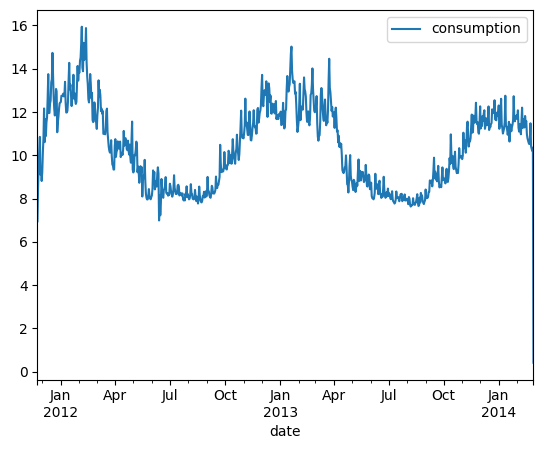

In [3]:
df_avg_consumption.plot(x="date", y="consumption")


<Axes: xlabel='date'>

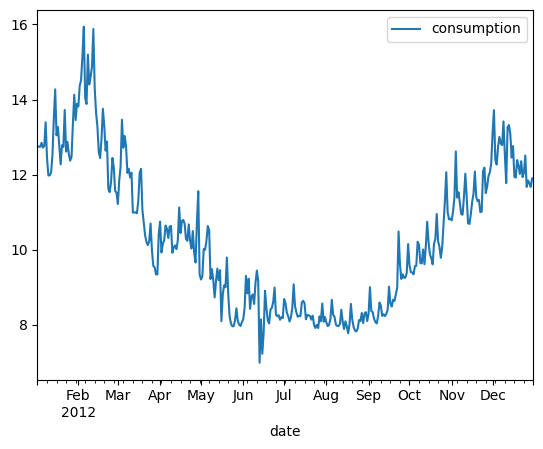

In [4]:
df_avg_consumption.query("date > '2012-01-01' & date < '2013-01-01'").plot(x="date", y="consumption")


In [5]:
df_avg_consumption["day_of_week"] = df_avg_consumption["date"].dt.dayofweek
df_avg_consumption["day_of_year"] = df_avg_consumption["date"].dt.dayofyear
df_avg_consumption["month"] = df_avg_consumption["date"].dt.month
df_avg_consumption["quarter"] = df_avg_consumption["date"].dt.quarter
df_avg_consumption["year"] = df_avg_consumption["date"].dt.year

df_avg_consumption.head()

,date,consumption,day_of_week,day_of_year,month,quarter,year
0,2011-11-23,6.952692,2,327,11,4,2011
1,2011-11-24,8.536480,3,328,11,4,2011
2,2011-11-25,9.499781,4,329,11,4,2011
3,2011-11-26,10.267707,5,330,11,4,2011
4,2011-11-27,10.850805,6,331,11,4,2011


In [6]:
training_mask = df_avg_consumption["date"] < "2013-07-28"
training_data = df_avg_consumption.loc[training_mask]
print(training_data.shape)

testing_mask = df_avg_consumption["date"] >= "2013-07-28"
testing_data = df_avg_consumption.loc[testing_mask]
print(testing_data.shape)

(613, 7)
(216, 7)


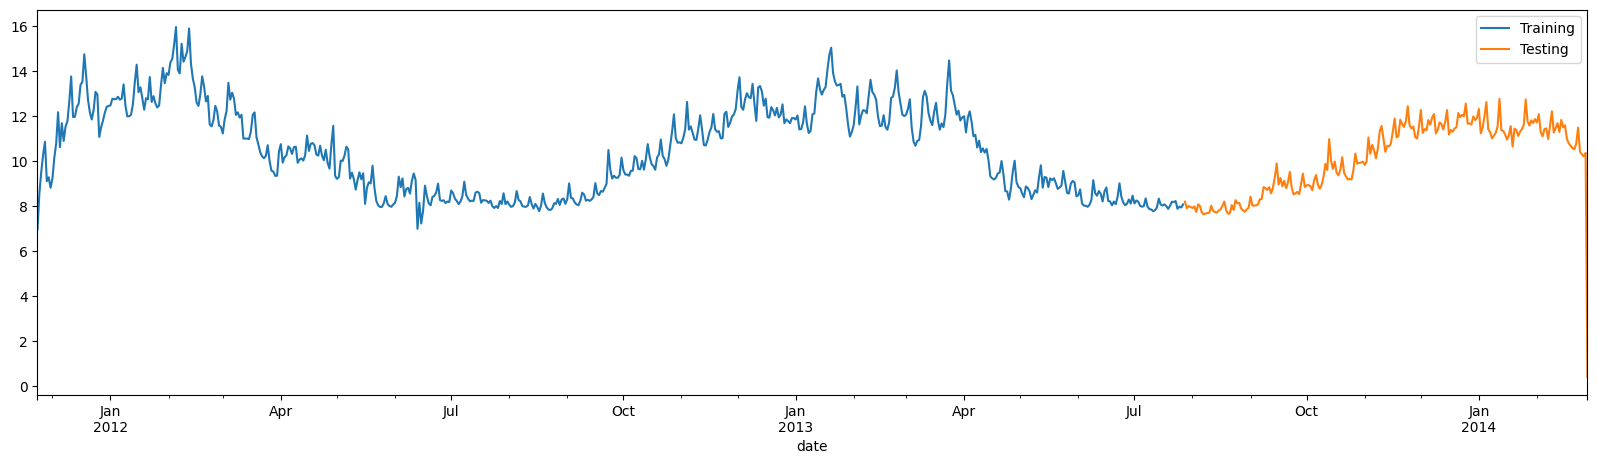

In [7]:
figure, ax = plt.subplots(figsize=(20, 5))
training_data.plot(ax=ax, label="Training", x="date", y="consumption")
testing_data.plot(ax=ax, label="Testing", x="date", y="consumption")
plt.show()

In [8]:
# Dropping unnecessary `date` column
training_data = training_data.drop(columns=["date"])
testing_dates = testing_data["date"]
testing_data = testing_data.drop(columns=["date"])

X_train = training_data[["day_of_week", "day_of_year", "month", "quarter", "year"]]
y_train = training_data["consumption"]

X_test = testing_data[["day_of_week", "day_of_year", "month", "quarter", "year"]]
y_test = testing_data["consumption"]

In [9]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# XGBoost
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.05],
    "n_estimators": [100, 300],
    "colsample_bytree": [0.3]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impo...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3],
                         'learning_rate': [0.01, 0.05], 'max_depth': [3, 4, 5],
                         'n_estimators': [100, 300]})

In [11]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
  mean_squared_error

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

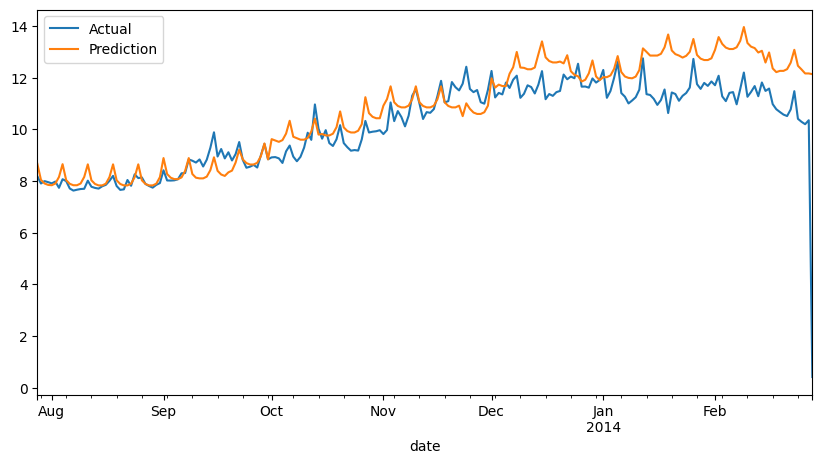

MAE: 0.7686541420987578
MSE: 1.499030547959475
MAPE: 0.19708401357186248


In [12]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)

In [13]:
df_weather = pd.read_csv("/content/drive/MyDrive/AIO2024/london_weather.csv")
print(df_weather.isna().sum())
df_weather.head()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64


,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [14]:
# Parsing dates
df_weather["date"] = pd.to_datetime(df_weather["date"], format="%Y%m%d")

# Filling missing values through interpolation
df_weather = df_weather.interpolate(method="ffill")

# Enhancing consumption dataset with weather information
df_avg_consumption = df_avg_consumption.merge(df_weather, how="inner", on="date")
df_avg_consumption.head()

<ipython-input-14-453c9762903c>:5: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_weather = df_weather.interpolate(method="ffill")


,date,consumption,day_of_week,day_of_year,month,quarter,year,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,2011-11-23,6.952692,2,327,11,4,2011,7.0,2.0,35.0,13.5,6.8,2.6,0.2,102720.0,0.0
1,2011-11-24,8.536480,3,328,11,4,2011,3.0,2.0,35.0,12.5,8.6,3.7,0.2,102710.0,0.0
2,2011-11-25,9.499781,4,329,11,4,2011,3.0,5.0,52.0,14.0,11.0,9.5,0.0,102450.0,0.0
3,2011-11-26,10.267707,5,330,11,4,2011,4.0,0.7,24.0,13.9,10.2,6.3,0.0,102580.0,0.0
4,2011-11-27,10.850805,6,331,11,4,2011,3.0,5.9,55.0,13.2,11.8,9.7,0.0,102130.0,0.0


In [16]:
training_mask = df_avg_consumption["date"] < "2013-07-28"
training_data = df_avg_consumption.loc[training_mask]
print(training_data.shape)

testing_mask = df_avg_consumption["date"] >= "2013-07-28"
testing_data = df_avg_consumption.loc[testing_mask]
print(testing_data.shape)

(613, 16)
(216, 16)


In [17]:
# Dropping unnecessary `date` column
training_data = training_data.drop(columns=["date"])
testing_dates = testing_data["date"]
testing_data = testing_data.drop(columns=["date"])

X_train = training_data[["day_of_week", "day_of_year", "month", "quarter", "year",\
                         "cloud_cover", "sunshine", "global_radiation", "max_temp",\
                         "mean_temp", "min_temp", "precipitation", "pressure",\
                         "snow_depth"]]
y_train = training_data["consumption"]


X_test = testing_data[["day_of_week", "day_of_year", "month", "quarter", "year",\
                         "cloud_cover", "sunshine", "global_radiation", "max_temp",\
                         "mean_temp", "min_temp", "precipitation", "pressure",\
                         "snow_depth"]]
y_test = testing_data["consumption"]

In [18]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# XGBoost
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.05],
    "n_estimators": [100, 300],
    "colsample_bytree": [0.3]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impo...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3],
                         'learning_rate': [0.01, 0.05], 'max_depth': [3, 4, 5],
                         'n_estimators': [100, 300]})

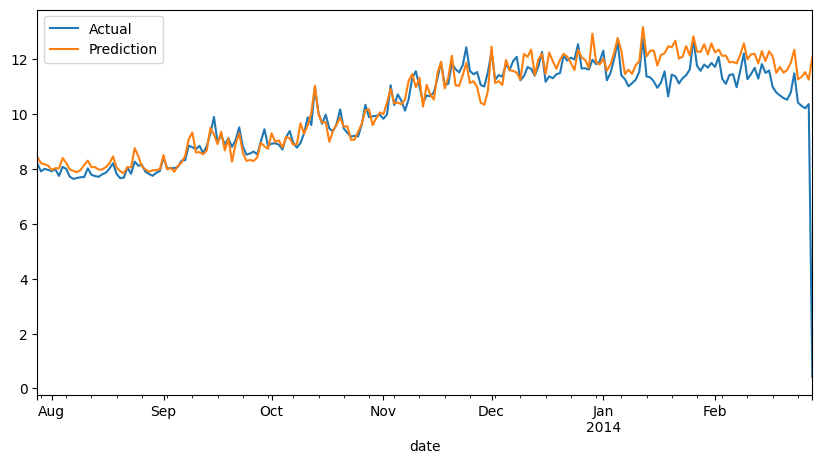

MAE: 0.4237410901122587
MSE: 0.8644555815084158
MAPE: 0.16432065473507365


In [19]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)